In [3]:
%load_ext autoreload
%autoreload 2
from src.data_processing import load_data
import itertools
import string


In [4]:
from src.ngrams import *
from src.string_similarity import levenshtein
import operator
from src.data_processing import print_progress
from matplotlib import pyplot as plt

In [5]:
task1, task2, task3, min_pairs, strings, pun_strings = load_data()

In [9]:
def ngrams(context):
    return [(context[i-1:i+2], three_gram_frequency(context[i-1:i+2])) for i in range(1, len(context)-1)]

In [14]:
from multiprocessing import Pool
contexts = [w['words'] for w in task1]

In [15]:
p = Pool(4)
ngram_frequencies = p.map(ngrams, contexts)

In [10]:
# with open("data/ngram_frequencies.json", 'w') as f:
#     json.dump(ngram_frequencies, f)

with open("data/ngram_frequencies.json") as f:
    ngram_frequencies = json.load(f)

In [11]:
no_ngram = []
for i, ngram in enumerate(ngram_frequencies):
    if 0 in [n[1] for n in ngram]:
        no_ngram.append((True, task1[i]['pun']))
    else:
        no_ngram.append((False, task1[i]['pun']))

In [34]:
no_toms = []
for i, ngram in enumerate(ngram_frequencies):
    tom_found = False
    for n in ngram:
        if 'Tom' in n[0]:
            tom_found = True
    if tom_found:
        continue
    no_toms.append(ngram)
print(len(no_toms))

1555


In [47]:
def calculate_scores(thresh, dataset):
    no_ngram = []
    for i, ngram in enumerate(dataset):
        if any([n[1] <= thresh for n in ngram]):
            no_ngram.append((True, task1[i]['pun']))
        else:
            no_ngram.append((False, task1[i]['pun']))

    tp, tf, fp, fn = 0, 0, 0, 0
    for pred, gold in no_ngram:
        if pred and gold:
            tp += 1
        if not pred and not gold:
            tf += 1
        if pred and not gold:
            fp += 1
        if not pred and gold:
            fn += 1
            
    acc = (tp + tf) / len(dataset)
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = (2*(recall*prec)) / (recall + prec)
    print(tp, tf, fp, fn)
    print("Accuracy: {}\nPrecision: {}\nRecall: {}\nF1: {}".format(acc, prec, recall, f1))

In [48]:
calculate_scores(0, ngram_frequencies)

1196 267 242 75
Accuracy: 0.8219101123595506
Precision: 0.8317107093184979
Recall: 0.940991345397325
F1: 0.882982650424511


In [16]:
threshold = list(range(0, 10000))
accuracies, precisions, recalls, f1s = [], [], [], []
for thresh in threshold:
    
    no_ngram = []
    for i, ngram in enumerate(ngram_frequencies):
        if any([n[1] <= thresh for n in ngram]):
            no_ngram.append((True, task1[i]['pun']))
        else:
            no_ngram.append((False, task1[i]['pun']))
            
    tp, tf, fp, fn = 0, 0, 0, 0
    for pred, gold in no_ngram:
        if pred and gold:
            tp += 1
        if not pred and not gold:
            tf += 1
        if pred and not gold:
            fp += 1
        if not pred and gold:
            fn += 1

    acc = (tp + tf) / len(no_ngram)
    recall = tp / (tp + fn)
    prec = tp / (tp + fp)
    f1 = (2*(recall*prec)) / (recall + prec)
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(recall)
    f1s.append(f1)
#     print(tp, tf, fp, fn)
#     print("Accuracy: {}\nPrecision: {}\nRecall: {}\nF1: {}".format(acc, prec, recall, f1))

KeyboardInterrupt: 

In [31]:
%matplotlib inline

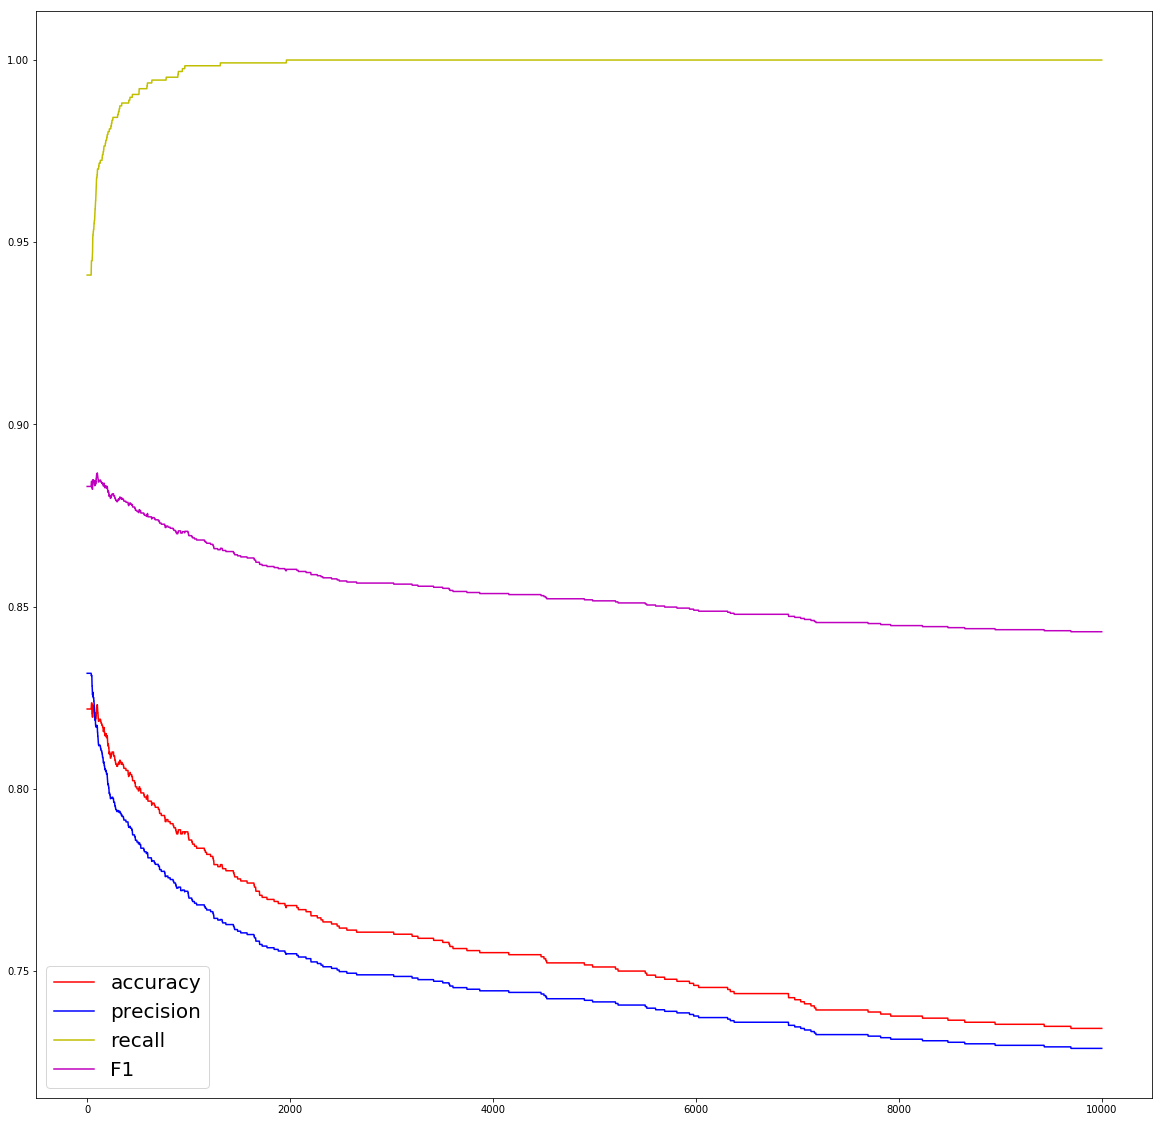

In [32]:
plt.figure(figsize=(20, 20))
plt.plot(threshold, accuracies, 'r', label="accuracy")
plt.plot(threshold, precisions, 'b', label="precision")
plt.plot(threshold, recalls, 'y', label="recall")
plt.plot(threshold, f1s, 'm', label="F1")
plt.legend(fontsize=20)

In [39]:
list(sorted(list(enumerate(f1s)), key=operator.itemgetter(1), reverse=True))

[(100, 0.8866498740554156),
 (97, 0.88656823910695),
 (98, 0.88656823910695),
 (101, 0.8864126527677929),
 (99, 0.8862491000719942),
 (93, 0.8861671469740635),
 (94, 0.8861671469740635),
 (95, 0.8861671469740635),
 (96, 0.8861671469740635),
 (102, 0.8860941430111391),
 (103, 0.8860941430111391),
 (92, 0.8857657657657658),
 (104, 0.8854578096947936),
 (105, 0.8854578096947936),
 (106, 0.8854578096947936),
 (90, 0.8853640951694306),
 (91, 0.8853640951694306),
 (107, 0.8851399856424982),
 (88, 0.8849621348719798),
 (89, 0.8849621348719798),
 (56, 0.8848263254113345),
 (108, 0.8848223896663078),
 (129, 0.8847530422333572),
 (130, 0.8847530422333572),
 (131, 0.8847530422333572),
 (62, 0.8846715328467153),
 (63, 0.8846715328467153),
 (64, 0.8846715328467153),
 (117, 0.8846704871060173),
 (118, 0.8846704871060173),
 (119, 0.8846704871060173),
 (120, 0.8846704871060173),
 (121, 0.8846704871060173),
 (122, 0.8846704871060173),
 (123, 0.8846704871060173),
 (124, 0.8846704871060173),
 (125, 0.884

In [21]:
for index, (recovered, target) in enumerate(min_pairs):
    if index < 199:
        continue
    print("{} / {}".format(index, len(min_pairs)))
    targeted_word = task2[index]['target']
    context = task2[index]
    
    target_index = context['words'].index(targeted_word)
    three_gram = context['words'][target_index-1:target_index+2]
    if len(three_gram) != 3:
        skips += 1
        continue
    if three_gram[0] == "Tom":
        skips += 1
        continue
    
    original_frequency = three_gram_frequency(three_gram)
    
    scores = {}
    other_three_grams = get_three_gram_wildcard(three_gram[0], three_gram[2])
    
    for i, (gram, freq) in zip(range(len(other_three_grams)), other_three_grams.items()):
        diff = freq - original_frequency
        phonetic_distance = levenshtein(gram.split()[1], three_gram[1])
        scores[gram.split()[1]] = diff / ((phonetic_distance+1) ** 3)
    all_scores.append(sorted(scores.items(), key=operator.itemgetter(1), reverse=True))


199 / 1098
200 / 1098
201 / 1098
202 / 1098
/home/doogy/Data/ngrams/3grams/c1/symbols/,.gz
203 / 1098
204 / 1098
205 / 1098
206 / 1098
207 / 1098
208 / 1098
209 / 1098
210 / 1098
211 / 1098
212 / 1098
213 / 1098
214 / 1098
215 / 1098
216 / 1098
217 / 1098
218 / 1098
219 / 1098
220 / 1098
221 / 1098
222 / 1098
223 / 1098
224 / 1098
225 / 1098
226 / 1098
227 / 1098
228 / 1098
229 / 1098
230 / 1098
231 / 1098
232 / 1098
233 / 1098
234 / 1098
235 / 1098
236 / 1098
237 / 1098
238 / 1098
239 / 1098
240 / 1098
241 / 1098
242 / 1098
243 / 1098
244 / 1098
245 / 1098
246 / 1098
247 / 1098
248 / 1098
249 / 1098
250 / 1098
251 / 1098
252 / 1098
/home/doogy/Data/ngrams/3grams/c1/symbols/,.gz
253 / 1098
254 / 1098
255 / 1098
256 / 1098
257 / 1098
258 / 1098
259 / 1098
260 / 1098
261 / 1098
262 / 1098
263 / 1098
264 / 1098
265 / 1098
266 / 1098
267 / 1098
268 / 1098
269 / 1098
270 / 1098
271 / 1098
272 / 1098
273 / 1098
274 / 1098
275 / 1098
276 / 1098
277 / 1098
278 / 1098
279 / 1098
280 / 1098
281 

863 / 1098
864 / 1098
865 / 1098
866 / 1098
867 / 1098
868 / 1098
869 / 1098
870 / 1098
871 / 1098
872 / 1098
873 / 1098
874 / 1098
875 / 1098
876 / 1098
877 / 1098
878 / 1098
879 / 1098
880 / 1098
881 / 1098
882 / 1098
883 / 1098
884 / 1098
885 / 1098
886 / 1098
887 / 1098
888 / 1098
889 / 1098
890 / 1098
891 / 1098
892 / 1098
893 / 1098
894 / 1098
/home/doogy/Data/ngrams/3grams/c1/symbols/'.gz
895 / 1098
896 / 1098
897 / 1098
898 / 1098
899 / 1098
900 / 1098
901 / 1098
902 / 1098
903 / 1098
904 / 1098
905 / 1098
906 / 1098
907 / 1098
908 / 1098
909 / 1098
910 / 1098
911 / 1098
912 / 1098
913 / 1098
914 / 1098
915 / 1098
916 / 1098
917 / 1098
918 / 1098
919 / 1098
/home/doogy/Data/ngrams/3grams/c1/symbols/?.gz
920 / 1098
921 / 1098
922 / 1098
923 / 1098
924 / 1098
925 / 1098
926 / 1098
927 / 1098
/home/doogy/Data/ngrams/3grams/c1/symbols/?.gz
928 / 1098
929 / 1098
930 / 1098
931 / 1098
932 / 1098
933 / 1098
934 / 1098
935 / 1098
936 / 1098
937 / 1098
938 / 1098
939 / 1098
940 / 1098
9

In [25]:
sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

In [29]:
len(all_scores)

for s in all_scores:
    print(s[:3])

[('world', 69140.32069970845), ('office', 43852.18518518518), ('time', 31601.36111111111)]
[('guy', 501.77777777777777), ('news', 495.078125), ('guys', 459.7037037037037)]
[('well', 680.89453125), ('good', 658.5276967930029), ('large', 593.24)]
[('over', 32173.62962962963), ('used', 15226.96), ('here', 14897.03125)]
[('staring', 507.25), ('writing', 54.264), ('popularity', 41.29766803840878)]
[('available', 5032.727023319616), ('required', 3484.37109375), ('present', 1973.273148148148)]
[('is', 147754.0), ('up', 76417.03703703704), (')', 53072.555555555555)]
[('got', 427.488), ('had', 220.25), ('been', 206.4375)]
[('status', 28634.71759259259), ('own', 28485.703125), ('needs', 22697.504)]
[]
[('inclined', 6.886297376093294), ('active', 5.37037037037037), ('speaking', 4.23046875)]
[('hole', 653.074074074074), ('more', 625.03125), ('boy', 579.84375)]
[('Bragg', 14.75), ('Douglas', 10.912536443148689), ('Lim', 1.08984375)]
[('arms', 1174.3125), ('space', 904.2731481481482), ('it', 598.139

In [21]:
ngram_frequencies[8]

[(['Two', 'construction', 'workers'], 526),
 (['construction', 'workers', 'had'], 1987),
 (['workers', 'had', 'a'], 7797),
 (['had', 'a', 'stairing'], 0),
 (['a', 'stairing', 'contest'], 0),
 (['stairing', 'contest', '.'], 0)]

In [22]:
res = get_three_gram_wildcard("a", "contest")

In [25]:
res['a staring contest']

4058

In [26]:
levenshtein('stairing', 'staring')

1

In [9]:
levenshtein('alghout', 'although')

3

In [28]:
three_gram_frequency("do n't like".split())

136

In [31]:
three_gram_frequency("at the orifice".split())

2876

In [ ]:
three